<a href="https://colab.research.google.com/github/vithika-karan/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition_Vithika_Karan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.
Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

###**Project Problem Statement**
We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.
The solution to this problem is by recognizing facial emotions.
This is a few shot learning live face emotion detection system. The model should be able to real-time
identify the emotions of students in a live class.

In [1]:
#importing libraries
#dataprocessing
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow
from tensorflow.keras.utils import to_categorical
import os
#model building
from keras.models import Sequential
from keras.layers import  Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
#metric
from sklearn.metrics import classification_report
#real time
import cv2
import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#reading csv
data = pd.read_csv("/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/fer2013.csv")

In [3]:
#data shape
data.shape

(35887, 3)

In [4]:
#first three rows of the dataset
data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [5]:
#check for null values
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no null values in the dataset.


In [6]:
#lets check the value counts in usage
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
#lets check the value counts in emotion column
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

There are counts for seven emotions. Let's try to explore the images for these classes.

####**Exploratory Data Analysis**

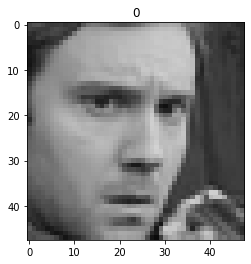

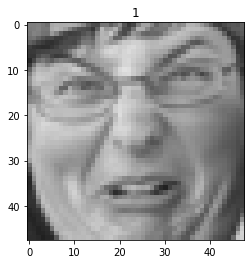

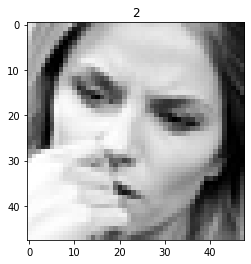

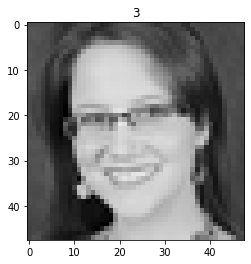

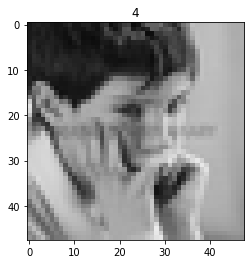

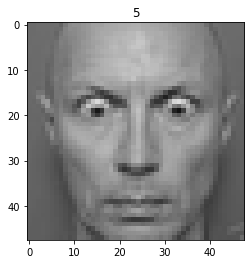

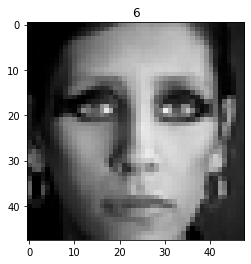

In [8]:
def show_img(df_row,pixel_string_col,class_col):
  '''The function takes in pixels in the form of strings and 
    respective class of the picture; preprocessess it and returns an array of image matrix of 48X48 
    and the class which can be easily plotted to visualize the image.
    Parameters:
    df_row: A row of a dataframe which has two columns, one containing pixels in string datatype
    and other labelled class
    pixel_string_col: Name of the column containing the pixels (dtype:string)
    class_col: Name of the column containing class (dtype:string)'''
  #pass observation and gather pixel and emotion class
  pixels = df_row[pixel_string_col]
  label = df_row[class_col]
  #split object and convert to array
  pic = np.array(pixels.split())
  pic = pic.reshape(48,48)
  image = np.zeros((48,48,3))
  #slice image and put the picture in three channels
  image[:,:,0] = pic
  image[:,:,1] = pic
  image[:,:,2] = pic
  #return image array and emotion
  return np.array([image.astype(np.uint8), label])

#iterate over all emotions and plot the pixels through the function
import matplotlib.pyplot as plt
for emotion in range(1,8):
    picture = data[data['emotion'] == emotion-1].iloc[0]
    picture = show_img(picture,'pixels','emotion')
    plt.imshow(picture[0])
    plt.title(picture[1])
    plt.show()  

**Data Description**

The data consists of grayscale images of faces at a resolution of 48x48 pixels. The faces have been automatically registered such that they are more or less centred in each image and take up around the same amount of area.

The goal is to categorize each face into one of seven categories based on the emotion expressed in the facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). There are 28,709 examples in the training set and 3,589 examples in the public test set.

Text(0.5, 1.0, 'Emotion Distribution')

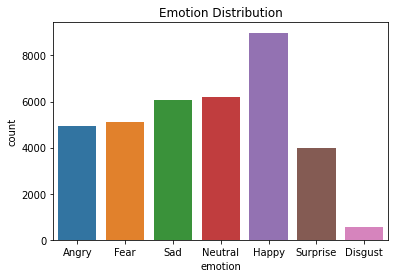

In [9]:
#plotting a bar graph of the emotions
#create dic of emotions
emo_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise',6:'Neutral'}
#creating a copy of data with actual categorial emotions
df1 = data.copy()
df1['emotion'] = df1['emotion'].map(emo_dict)
#plotting
sns.countplot(x=df1['emotion'])
plt.title('Emotion Distribution')

The number of happy pictures are the highest and disgusted pictures lowest in the dataset.

####**Data Pre-processing**



In [10]:
#splitting the data into train, validation and test set
train_data = data[data['Usage']=='Training']
val_data   = data[data['Usage']=='PublicTest']
test_data  = data[data['Usage']=='PrivateTest']
print("The shape of training set is: {}, \nThe shape of validation set is: {}, \nThe shape of test set is: {}".format(train_data.shape, val_data.shape, test_data.shape))

The shape of training set is: (28709, 3), 
The shape of validation set is: (3589, 3), 
The shape of test set is: (3589, 3)


In [11]:
#resetting index and dropping usage
for elem in [train_data,val_data,test_data]:
    elem.reset_index(drop=True, inplace= True)
    elem.drop('Usage',axis=1,inplace=True)

In [12]:
#data preparation for test
test_data['pixels'] = test_data['pixels'].apply(lambda pixels : [int(pixel) for pixel in pixels.split()])
X_test = np.array(test_data['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)/255.0 
y_test = to_categorical(test_data['emotion'],num_classes = 7,dtype ="uint8")

The method flow from directory for Image Data Augmentation expects that images belonging to different classes are present in different folders but are inside the same parent folder. Let's create that.

In [13]:
#main data directory path
path = "/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/"

In [14]:
#image data directory creation
def create_dir(path,class_list):
  ''' The function takes in the path and list of the classes to 
        create directories for different  classes
        Parameters:
        path: The path where train and validation directories needs to be created.
        class_list: The list of labels in the dataset.''' 
  #Create train and validation directories
  train_path = os.path.join(path,'train')
  val_path = os.path.join(path,'valid')
  os.mkdir(train_path)
  os.mkdir(val_path) 
  for data_path,cat in {train_path:'train-',val_path:'valid-'}.items():
    for label in class_list:
      label_dir = os.path.join(data_path,cat+str(label))
      os.mkdir(label_dir)
  

In [ ]:
#creating directories
create_dir(path,[0,1,2,3,4,5,6])

In [15]:
train_path = "/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/train"
val_path =  "/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/valid"

In [16]:
#saving images
def save_imgs(df,df_path,pixel_col,class_col,class_list,prefix):
  '''This function takes in the dataframes and 
     creates images and saves images in directories.
     Parameters: 
     df: Dataframe that needs to be converted.
     df_path: Path to the directory (dtype-string)
              Example- If the training dataframe is fed, df_path should be the path
              to the train directory created.
     pixel_col: Name of the column containing pixels in string object
     class_col: Name of the column for data labels
     prefix: train- for training set, valid- for validation set  '''
  
  for i in range(len(df)):
      pixel_string = df[pixel_col][i]
      pixels = list(map(int, pixel_string.split()))
      
      matrix = np.array(pixels).reshape(48,48).astype(np.uint8)
      img = Image.fromarray(matrix)
      for label in class_list:
        if str(df[class_col][i]) in prefix + str(label):
            img.save(df_path +'/'+ prefix + str(label)+'/'+ prefix + str(label)+'-'+str(i)+'.png')
        else:
          continue


In [ ]:
#train images
save_imgs(train_data,train_path,'pixels','emotion',[0,1,2,3,4,5,6],'train-')
#validation images
save_imgs(val_data,val_path,'pixels','emotion',[0,1,2,3,4,5,6],'valid-')

In [17]:
#Image preprocessing
from keras.preprocessing.image import ImageDataGenerator
def img_data_gen(train_path,val_path,target_size,batch_size,color_mode,class_mode):
  ''' The function generates augmented data rescales the validation images given the paths.
  Parameters:
  train_path: path to the train directory of the images
  val_path: path to the validation directory of images
  target_size: image target size; example: (48*48)
  batch_size: The batches in which the data is supposed to be fed
  color_mode: example: 'grayscale' or 'rgb'
  class_mode: example: 'binary' or 'categorical'
   '''
  #Initialising the generators for the train and validation set
  #The rescale parameter ensures the input range in [0, 1] 
  train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range = 10,horizontal_flip = True,width_shift_range=0.1,height_shift_range=0.1,
                                    fill_mode = 'nearest')
  val_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented

  train_generator = train_datagen.flow_from_directory(
          train_path,
          target_size=target_size,
          batch_size=batch_size,
          color_mode=color_mode,
          seed = 42,
          shuffle= True,
          class_mode=class_mode)
    
  val_generator = val_datagen.flow_from_directory(
          val_path,
          target_size=target_size,
          batch_size=batch_size,
          color_mode=color_mode,
          seed = 42,
          shuffle = True,
          class_mode=class_mode)
  
  return train_generator, val_generator

In [18]:
#image generators
train_gen, val_gen = img_data_gen(train_path,val_path,target_size=(48,48),batch_size=64,color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


####**Model Building**

In [ ]:
# model
model = Sequential()
num_classes = 7
#the 1st block
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#the 2nd block
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#the 3rd block
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#the 4th block
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#Flatten and output
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
# summary layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
#model compiling
optimizer = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#training
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience = 15, verbose=1,restore_best_weights=True)

epochs = 100
#fitting
history=model.fit_generator(train_gen,
                steps_per_epoch=len(train_data)//64,
                epochs=epochs,
                callbacks=earlystop,
                verbose= 1,
                validation_data=val_gen,
                validation_steps=len(val_data)//64)

Epoch 1/100
448/448 [==============================] - 91s 202ms/step - loss: 1.9615 - accuracy: 0.3032 - val_loss: 1.6287 - val_accuracy: 0.3770
Epoch 2/100
448/448 [==============================] - 91s 202ms/step - loss: 1.8459 - accuracy: 0.3469 - val_loss: 1.7281 - val_accuracy: 0.3839
Epoch 3/100
448/448 [==============================] - 90s 201ms/step - loss: 1.7471 - accuracy: 0.3819 - val_loss: 1.6788 - val_accuracy: 0.4191
Epoch 4/100
448/448 [==============================] - 90s 202ms/step - loss: 1.6619 - accuracy: 0.4141 - val_loss: 1.5967 - val_accuracy: 0.4467
Epoch 5/100
448/448 [==============================] - 90s 202ms/step - loss: 1.5809 - accuracy: 0.4385 - val_loss: 1.6362 - val_accuracy: 0.4713
Epoch 6/100
448/448 [==============================] - 90s 201ms/step - loss: 1.5101 - accuracy: 0.4699 - val_loss: 1.4835 - val_accuracy: 0.4997
Epoch 7/100
448/448 [==============================] - 90s 200ms/step - loss: 1.4475 - accuracy: 0.4927 - val_loss: 3.1870 -

Restored the best model weights, which was for the epoch 45 with the following result:
* loss: 0.7075 - accuracy: 0.7381 - val_loss: 0.9825 - val_accuracy: 0.6643

####**Model Evaluation**

In [ ]:
#saving the history of the model in dataframe  
model_df = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Loss Plots for Training and Validation Sets')

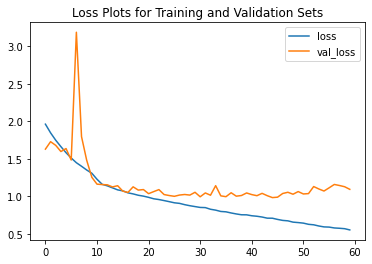

In [ ]:
#Plotting Loss 
model_df[['loss','val_loss']].plot()
plt.title("Loss Plots for Training and Validation Sets")

Text(0.5, 1.0, 'Accuracy Plots for Training and Validation Sets')

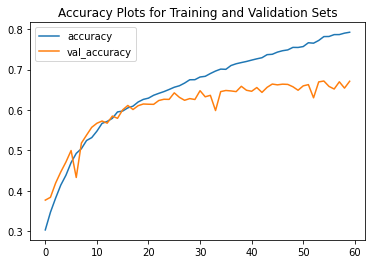

In [ ]:
#Plotting accuracy 
model_df[['accuracy','val_accuracy']].plot()
plt.title("Accuracy Plots for Training and Validation Sets")

**Predictions on Test Data**

In [ ]:
#test predictions 
true_y  = np.argmax(y_test,axis=1)
pred_y = np.argmax(model.predict(X_test),axis=1)
print(classification_report(true_y,pred_y))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       491
           1       0.83      0.62      0.71        55
           2       0.53      0.49      0.51       528
           3       0.90      0.86      0.88       879
           4       0.51      0.58      0.54       594
           5       0.78      0.75      0.77       416
           6       0.62      0.72      0.67       626

    accuracy                           0.68      3589
   macro avg       0.69      0.65      0.67      3589
weighted avg       0.68      0.68      0.68      3589



The predictions on the test set are pretty great with accuracy of 0.68 which implies generalization of the model is good as compared to the training results.


####**Save the Model**

In [ ]:
#saving model 
model.save(path+'Emotion Detection Model/emotion_detection.h5')

####**Real Time Emotion Detection**

The following code for real time emotion detection was run on local device and the results are attached along with it.

In [ ]:
#load model
model = tensorflow.keras.models.load_model(path+'Emotion Detection Model/emotion_detection.h5')

In [ ]:
face_haar_cascade = cv2.CascadeClassifier(path+'haarcascade_frontalface_default.xml')

In [ ]:
#code for real time detection
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,img=cap.read()
    height, width, channel = img.shape
    sub_img = img[0:int(height/6),0:int(width)]
    heading = np.ones(sub_img.shape, dtype=np.uint8)*0
    result = cv2.addWeighted(sub_img, 0.82, heading,0.18, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    font_thickness = 2
    lable_color = (0, 255, 0)
    lable = "Emotion Detection"
    lable_dimension = cv2.getTextSize(lable,font,font_scale,font_thickness)[0]
    textX = int((result.shape[1] - lable_dimension[0]) / 2)
    textY = int((result.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(result, lable, (textX,textY), font, font_scale, (0,0,0), font_thickness)
    # prediction part 
    gray_image= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #detect faces on screen
    faces = face_haar_cascade.detectMultiScale(gray_image)
    try:
        for (x,y, w,h) in faces:
            #frame  rectangle
            cv2.rectangle(img, pt1 = (x,y),pt2 = (x+w, y+h), color = (0,0,255),thickness = 2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = tensorflow.keras.preprocessing.image.img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            #normalize
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            #map predictions
            emotion_detection = ('Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(img,emotion_prediction, (int(x+w/3),int(y)),font,0.9, lable_color,2)
            
    except :
        pass
    img[0:int(height/6),0:int(width)] = result
    cv2.imshow('Emotion Detection', img)
    #press q to close
    if cv2.waitKey(1) == ord('q'):
        break
#release and destroy video data
cap.release()
cv2.destroyAllWindows()

The model pretty accurately detected all the emotions beside disgust. The training daata for the emotion class - disgust were pretty low as compared to others. Here are the results:

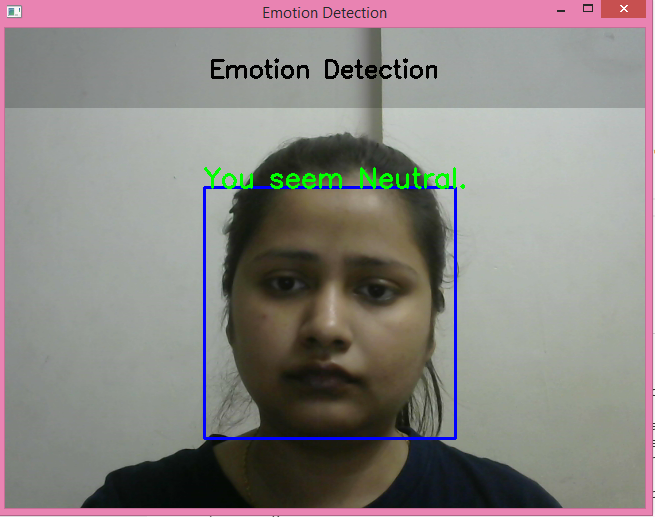

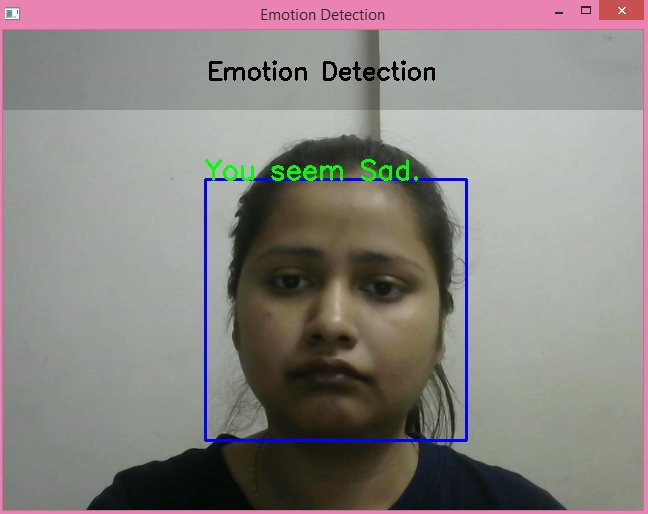

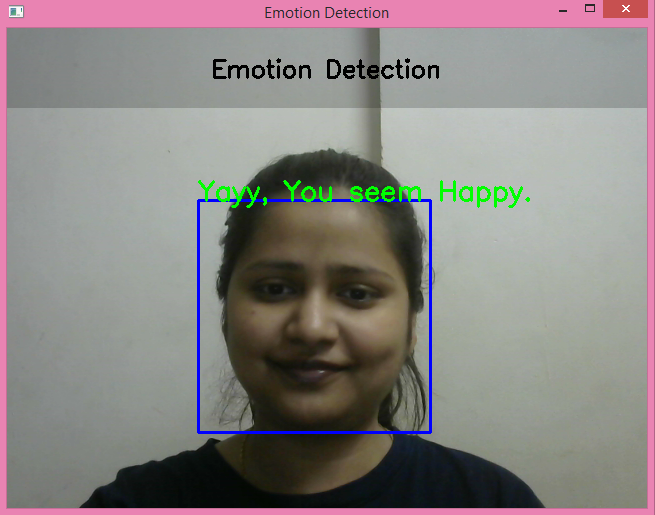

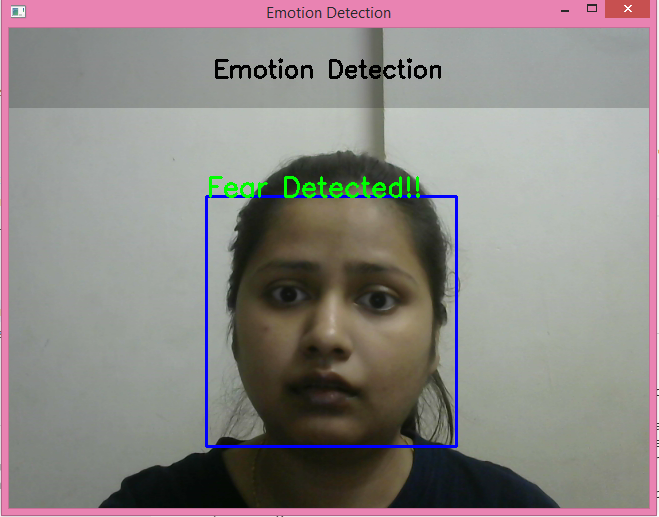

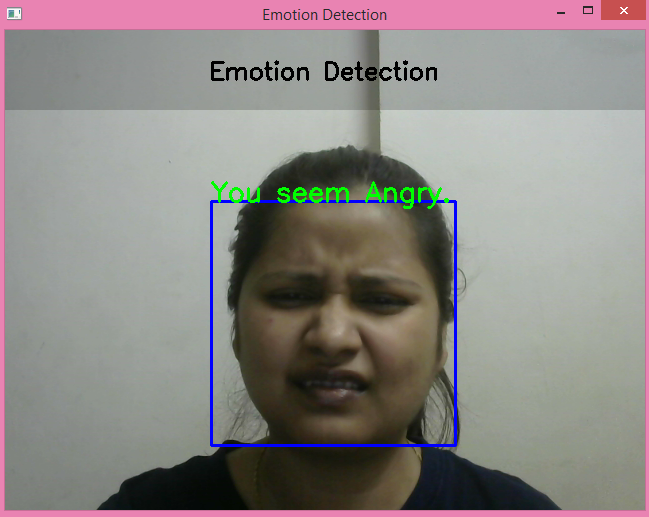

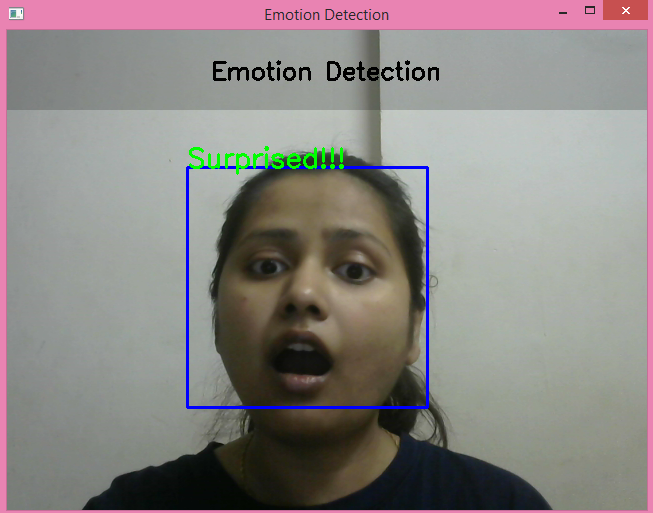

####**Conclusion**

With this, the notebook comes to an end. Some important conclusions in the project includes:
* Model Training results: loss: 0.7075 - accuracy: 0.7381 - val_loss: 0.9825 - val_accuracy: 0.6643
* Model Test Results:

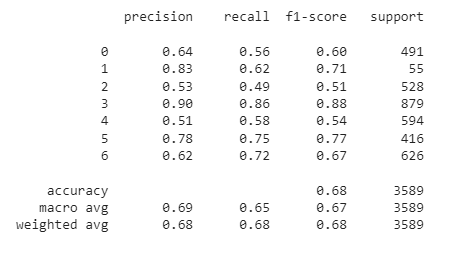

* Next step is to create a streamlit web-app for the same and deploy it for real time use. Further work can be explored in the github repository.

Link: https://github.com/vithika-karan/Face-Emotion-Recognition
